# SBA

# import packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sweetviz as sv
import missingno as msno
import time 
import sys
import os
import csv
from bs4 import BeautifulSoup
import requests
import re

![SBA](https://youth.gov/sites/default/files/2021-08/SBA-Formatted.gif)

## Read Data

In [3]:
try:
    df = pd.read_csv('/home/apprenant/Documents/archive/SBAnational.csv')
except:
    df = pd.read_csv('C:/Users/emada/Downloads/loan_project (1)/SBAnational.csv')


df = df.head(2000)

<ipython-input-3-dea43f210dd6>:4: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/emada/Downloads/loan_project (1)/SBAnational.csv')


### Remove "A" in "ApprovalFY" column and replace it with "" then change type to int

In [4]:
%%timeit
df['ApprovalFY'] = df['ApprovalFY'].replace('A', '', regex=True).astype(int)

129 µs ± 2.59 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Creat sweetvis Repport
![sweetvis](https://warehouse-camo.ingress.cmh1.psfhosted.org/210c4eb7317c8b0d2e7d0784b1a9697c096050ef/687474703a2f2f636f6f6c74696d696e672e636f6d2f53562f4c61796f75742d416e696d332e676966)

In [5]:
# report = sv.analyze(df)
# report.show_html('report.html')


##  The target feature (y) is : MSI_Status (CHGOFF and PIF)

In [6]:
df['MIS_Status'].value_counts()

P I F     1722
CHGOFF     270
Name: MIS_Status, dtype: int64

### Data cleaning

In [7]:
df.describe()

,LoanNr_ChkDgt,Zip,NAICS,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1.006913e+09,41977.370500,372387.909000,2000.794500,86.330500,8.719000,1.336500,0.591500,0.906000,1859.060500,0.571500
std,3.765440e+06,34716.059039,264488.308164,4.059866,67.940225,46.521459,0.503383,3.241586,4.336192,10379.369693,0.739027
min,1.000014e+09,0.000000,0.000000,1972.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.003863e+09,6704.000000,0.000000,1997.000000,48.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,1.006921e+09,33836.500000,444130.000000,2001.000000,72.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.010178e+09,78396.000000,541940.000000,2004.000000,84.000000,8.000000,2.000000,0.000000,0.000000,1.000000,1.000000
max,1.013533e+09,99999.000000,928120.000000,2006.000000,309.000000,2000.000000,2.000000,55.000000,93.000000,90725.000000,2.000000


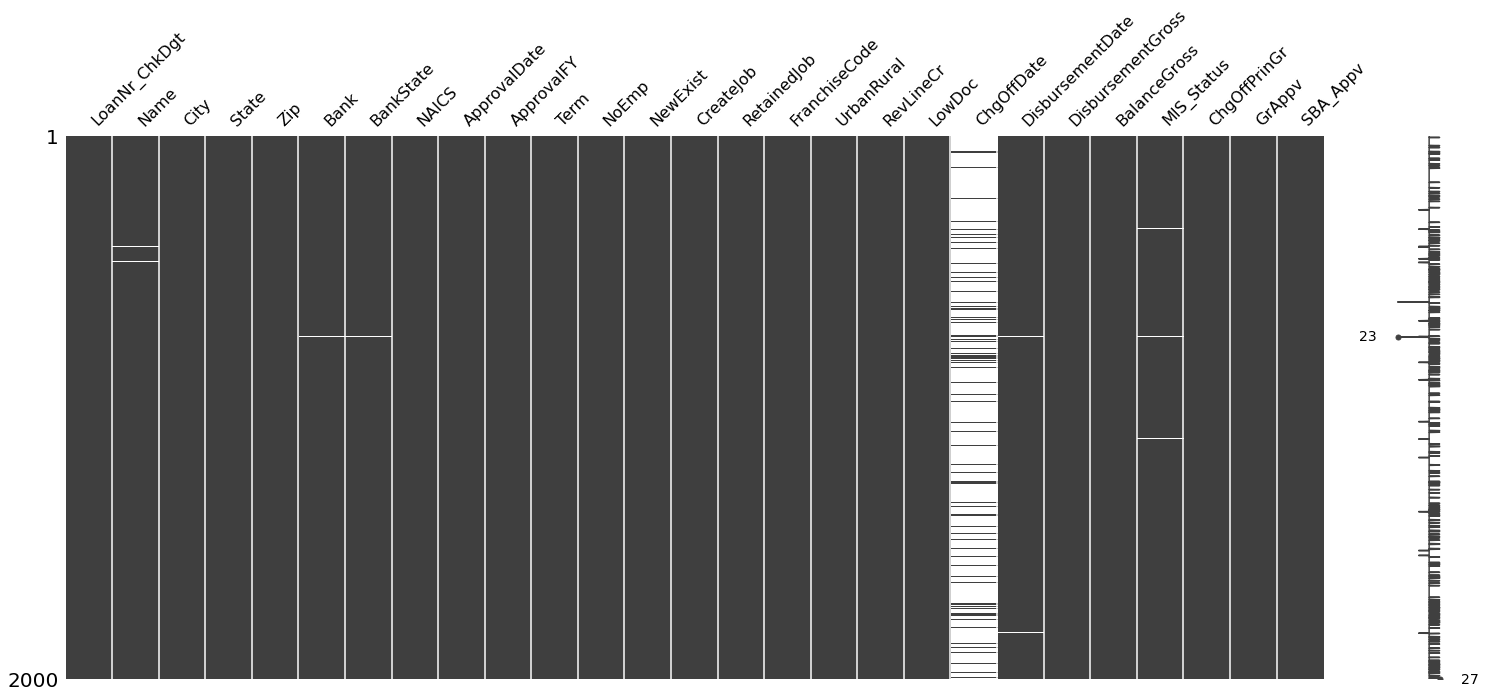

In [8]:
msno.matrix(df);

In [9]:
print(df.isnull().sum())

LoanNr_ChkDgt           0
Name                    4
City                    0
State                   0
Zip                     0
Bank                    4
BankState               4
NAICS                   0
ApprovalDate            0
ApprovalFY              0
Term                    0
NoEmp                   0
NewExist                0
CreateJob               0
RetainedJob             0
FranchiseCode           0
UrbanRural              0
RevLineCr               0
LowDoc                  0
ChgOffDate           1714
DisbursementDate        9
DisbursementGross       0
BalanceGross            0
MIS_Status              8
ChgOffPrinGr            0
GrAppv                  0
SBA_Appv                0
dtype: int64


### Replace "$" with "" in numeric columns

In [10]:
# create a list of all numeric columns
columns_to_transform_to_int = ["DisbursementGross","BalanceGross","ChgOffPrinGr","GrAppv","SBA_Appv"]


for col in columns_to_transform_to_int:
    df[col] = df[col].str.replace("$", "")
    df[col] = df[col].str.replace(",", "")
    df[col] = df[col].astype(float)
    

df['Term'] = df['Term'].astype(int)

<ipython-input-10-2538c257e751>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("$", "")


## Cleaning LowDoc column

In [11]:
df['LowDoc'] = df['LowDoc'].replace({'0': 'N'})
df['LowDoc'].value_counts()

N    1787
Y     213
Name: LowDoc, dtype: int64

#### Keep only "N" and "Y"

In [12]:
df = df[df['LowDoc'].isin(['N','Y'])]
df['LowDoc'].value_counts()

N    1787
Y     213
Name: LowDoc, dtype: int64

## Cleaning RevLineCr column

In [13]:
df['RevLineCr'] = df['RevLineCr'].replace({'0': 'N', 'T':'Y'})
df['RevLineCr'].value_counts()

N    1418
Y     582
Name: RevLineCr, dtype: int64

#### Keep only "N" and "Y"

In [14]:
df = df[df['RevLineCr'].isin(['N','Y'])]
df['RevLineCr'].value_counts()

N    1418
Y     582
Name: RevLineCr, dtype: int64

### Find State's df missing values using Zip codes

In [15]:
# def getCityState(zipCode):
#     zipCode = str(zipCode)
#     url = "http://www.city-data.com/zips/" + zipCode + ".html"
#     r = requests.get(url)
#     data = r.text
#     soup = BeautifulSoup(data)
#     if soup.findAll(text="City:") ==[]:
#         cityNeeded = soup.findAll(text="Cities:")
#         for t in cityNeeded:
#             city_name = t.find_next('a').string
#             if city_name:
#                 return city_name
#                 time.sleep(0.5)
#     else:
#         cityNeeded = soup.findAll(text="City:")
#         for t in cityNeeded:
#             city_name = t.find_next('a').string
#             if city_name:
#                 return city_name
#                 time.sleep(0.5)
#     return None


# df['Zip'] = df['Zip'].astype(int)


# # Find the rows where the 'State' column is missing
# missing_state_rows = df[df['State'].isnull()]

# # Use the 'apply' function to apply the 'getCityState' function to the 'Zip' column of the missing rows
# missing_state_rows['State'] = missing_state_rows['Zip'].apply(lambda x: getCityState(x))

# # Update the original DataFrame with the new values for the 'State' column
# df.update(missing_state_rows)

# df['State'] = df['State'].str[-2:]


# df[df['State'].isna()]


### We still have 3 States missing values bescause of there non valide Zip code

## Drop not important features

In [16]:
dictionnaire =  {"11":"Agriculture, forestry, fishing and hunting","72":"Accommodation and food services","21":"Mining, quarrying, and oil and gas extraction","22":
"Utilities","23":"Construction","31":"Manufacturing","32":"Manufacturing","33":"Manufacturing","42":"Wholesale trade","44":"Retail trade","45":"Retail trade","48":" Transportation and warehousing", "49":"Transportation and warehousing", "51":"Information","52":"Finance and insurance", "53":"Real estate and rental and leasing","54":"Professional, scientific, and technical services","55":"Management of companies and enterprises","56":"Administrative and support and waste management and remediation services","61":"Educational services","62":"Health care and social assistance","71":"Arts, entertainment, and recreation","81":"Other services (except public administration)", "92": "Public administration", "0" : "Other"}

df['NAICS'] = df['NAICS'].astype(str).str[:2]

df["Categorie_NAICS"] = df["NAICS"].map(dictionnaire)

# df.Categorie.value_counts(dropna=False)

df["Categorie_NAICS"].value_counts(dropna=False)

Other                                                                       532
Retail trade                                                                259
Professional, scientific, and technical services                            163
Manufacturing                                                               150
Construction                                                                142
Other services (except public administration)                               138
Health care and social assistance                                           129
Wholesale trade                                                             105
Accommodation and food services                                              93
Administrative and support and waste management and remediation services     87
 Transportation and warehousing                                              56
Information                                                                  38
Real estate and rental and leasing      

In [17]:
df.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
       'Categorie_NAICS'],
      dtype='object')

In [18]:
cols_to_drop = ['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'Bank', 'BankState', 'ApprovalDate', 'RetainedJob','ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'BalanceGross', 'SBA_Appv', 'ChgOffPrinGr']
df_cleaned = df.copy()
df_cleaned.drop(columns=cols_to_drop, inplace=True)


## Drop from df all missing values in columne "MSI_Status"

In [19]:
df_cleaned.dropna(subset=['MIS_Status'], inplace=True)


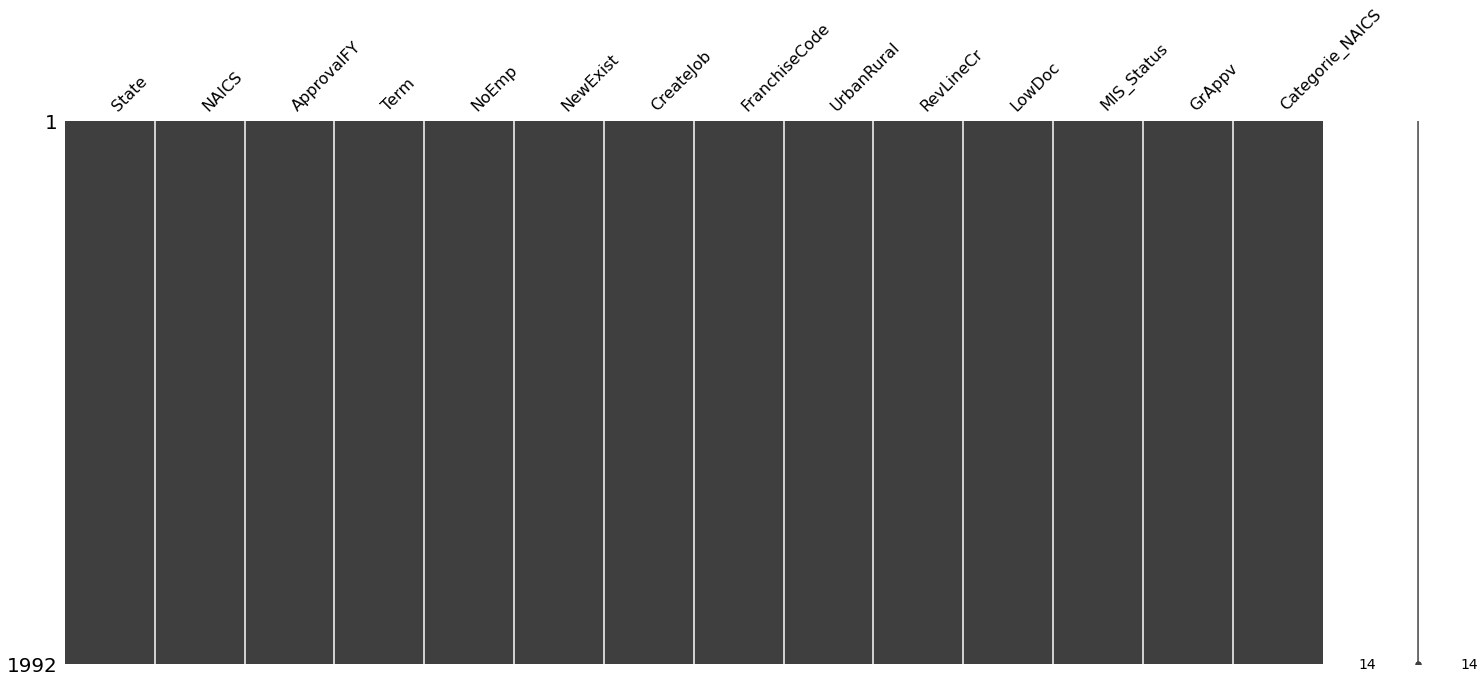

In [20]:
msno.matrix(df_cleaned);

In [21]:
df_cleaned.isna().sum()

State              0
NAICS              0
ApprovalFY         0
Term               0
NoEmp              0
NewExist           0
CreateJob          0
FranchiseCode      0
UrbanRural         0
RevLineCr          0
LowDoc             0
MIS_Status         0
GrAppv             0
Categorie_NAICS    0
dtype: int64

## Sum of Gross amount of loan approved
![All](https://media.tenor.com/6Hixx4SFAeQAAAAM/backing-you-get-yours.gif)

In [22]:
print(df['GrAppv'].sum())

252342302.0


In [23]:
y = df_cleaned.MIS_Status
X = df_cleaned.drop(columns=['MIS_Status'])

# Feature Selection

There are several ways to test the feature importance in a machine learning classification model. Some popular methods include:

- `Permutation Importance`: This method involves shuffling the values of a single feature and measuring the change in the model's performance. The idea is that if a feature is important, then shuffling its values should have a large impact on the model's performance.

- `Feature Importance from Tree-based Models`: Tree-based models like decision trees, random forests, and gradient boosting machines, can directly compute feature importance by looking at how much each feature contributes to the final decision. These models typically have an attribute such as feature_importances_ or coef_ which can be used to extract feature importance.

- `Recursive Feature Elimination (RFE)`: This method involves fitting the model with all the features and then recursively removing the feature with the lowest importance until a desired number of features is reached. The final set of features selected by this method is considered to be the most important.

- `LASSO Regression`: Lasso regression is a linear model that can be used for feature selection. It works by adding a penalty term to the linear regression model that shrinks the coefficients of less important features towards zero.

- `Partial dependence plots`: These plots show the relationship between a feature and the model's predictions. They can be used to understand how a feature affects the model's predictions and identify the most important features.

These are just a few of the many methods available for testing feature importance. The best method to use will depend on the specific model and dataset you're working with.

It's worth to mention that, feature importance can be influenced by the data distribution, data scale, data leakage, the model used, and the evaluation metric. Therefore, it's important to be careful interpreting the results of feature importance, and to use other techniques like cross-validation, permutation test, and visualization to confirm the feature importance.

### Permutation Importance 
is a technique you can use to determine the importance of each feature in your dataset. Here's an example of how you can implement permutation importance with your binary classification dataset:

1. First, you'll need to train a model on your dataset. For example, you can use a RandomForestClassifier or any other classifier model of your choice.

2. Next, you'll want to evaluate the model's performance using a performance metric such as accuracy, f1-score, or roc-auc.

3. Once you have a trained model and a performance metric, you can use the permutation_importance function from the sklearn.inspection library to measure the importance of each feature. This function takes the trained model, the input data, and the target variable as arguments.

In [24]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.9, random_state=42)

In [25]:
from sklearn.compose import make_column_selector, ColumnTransformer, make_column_transformer
# sklearn.compose: The sklearn.compose module is a submodule of the sklearn library for machine learning in Python. It provides functions for creating complex preprocessing and modeling pipelines.
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures,RobustScaler
#sklearn.preprocessing: The sklearn.preprocessing module is a submodule of the sklearn library that provides functions for preprocessing data, such as scaling and normalizing features, imputing missing values, and encoding categorical variables.
from sklearn.linear_model import Ridge,LinearRegression,Lasso, ElasticNet
# sklearn.linear_model: The sklearn.linear_model module is a submodule of the sklearn library that provides functions for fitting linear models for regression and classification.
from sklearn.pipeline import make_pipeline
# sklearn.pipeline: The sklearn.pipeline module is a submodule of the sklearn library that provides functions for creating and working with pipelines of transformers and models.
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve, RandomizedSearchCV, cross_val_score, KFold
# sklearn.model_selection: The sklearn.model_selection module is a submodule of the sklearn library that provides functions for splitting data into training and test sets, evaluating models using cross-validation, and hyperparameter tuning.
from sklearn.dummy import DummyRegressor
# sklearn.dummy: The sklearn.dummy module is a submodule of the sklearn library that provides simple dummy models for regression and classification.


from sklearn.impute import SimpleImputer
import numpy as np

def make_pipeline_to_ML(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.8, random_state=42)
    numerical_features = make_column_selector(dtype_include=np.number)
    categorical_features = make_column_selector(dtype_exclude= np.number)
    numerical_pipeline = make_pipeline(SimpleImputer(strategy='mean'),StandardScaler(with_mean=False))
    categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore'))
    preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                    (categorical_pipeline, categorical_features)
                                    )
    return preprocessor, X_train, X_test, y_train, y_test


# Create the pipeline
preprocessor, X_train, X_test, y_train, y_test = make_pipeline_to_ML(X,y)

# RandomForest
![forest](https://thumbs.gfycat.com/UncomfortableWelllitDrever-size_restricted.gif)

In [26]:
from sklearn.ensemble import RandomForestClassifier


# Add the RandomForestClassifier to the pipeline
clf = make_pipeline(preprocessor, RandomForestClassifier(random_state=42, max_depth = 10, class_weight='balanced'))

# Fit the pipeline on the training data
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)



#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.8872180451127819


In [27]:
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(clf, X_train, y_train, cv=5)

In [28]:
metrics.confusion_matrix(y_train, predicted)

array([[ 127,   83],
       [  79, 1304]], dtype=int64)

In [29]:
print(metrics.classification_report(y_train, predicted))

              precision    recall  f1-score   support

      CHGOFF       0.62      0.60      0.61       210
       P I F       0.94      0.94      0.94      1383

    accuracy                           0.90      1593
   macro avg       0.78      0.77      0.78      1593
weighted avg       0.90      0.90      0.90      1593



In [30]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      CHGOFF       0.63      0.62      0.62        60
       P I F       0.93      0.94      0.93       339

    accuracy                           0.89       399
   macro avg       0.78      0.78      0.78       399
weighted avg       0.89      0.89      0.89       399



In [31]:
metrics.f1_score(y_test, y_pred, average='weighted')

0.8868272213931694

In [32]:
metrics.confusion_matrix(y_test, y_pred)

array([[ 37,  23],
       [ 22, 317]], dtype=int64)

In [33]:
# create a new dataframe with feature names as index and feature importances as values
df_importances = pd.DataFrame({'feature_importance': clf.steps[1][1].feature_importances_}, index=clf.steps[0][1].get_feature_names_out())

# sort the dataframe by feature importances
df_importances.sort_values(by='feature_importance', ascending=False, inplace=True)

AttributeError: Estimator simpleimputer does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?

In [ ]:
df_importances.head(20)

,feature_importance
pipeline-1__Term,0.439898
pipeline-1__ApprovalFY,0.147669
pipeline-1__FranchiseCode,0.103624
pipeline-1__UrbanRural,0.069695
pipeline-1__GrAppv,0.062975
pipeline-1__NoEmp,0.024683
pipeline-2__RevLineCr_Y,0.022284
pipeline-2__RevLineCr_N,0.021731
pipeline-2__NAICS_0,0.019625
pipeline-2__Categorie_NAICS_Other,0.019465


In [ ]:
# data = list(zip(clf.feature_names_in_, clf.steps[1][1].feature_importances_))
# df_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
# df_importances

## Now we will try to find the best parameters for RandomForestClassifier with GridSearchCV

In [ ]:
clf.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler(with_mean=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f41d2c5a470>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    <sklearn.compose._column_transformer.make_column_selector ob

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {'randomforestclassifier__n_estimators': np.linspace(10, 1000, 100, dtype=int), 'randomforestclassifier__max_depth': np.linspace(5, 100, 5, dtype=int)}

# Create a random forest classifier object
clf = make_pipeline(preprocessor, RandomForestClassifier(class_weight='balanced'))

# Create the randomized search object
random_search = RandomizedSearchCV(clf, param_grid, n_iter=10, cv=5, random_state=42)

# Fit the randomized search to the data
random_search.fit(X, y)

# Print the best parameters and the best score
print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best parameters:  {'randomforestclassifier__n_estimators': 620, 'randomforestclassifier__max_depth': 76}
Best score:  0.9036107857583658


In [ ]:
# Define the parameter grid
param_grid = {'randomforestclassifier__n_estimators': np.linspace(10, 1000, 100, dtype=int), 'randomforestclassifier__max_depth': np.linspace(5, 100, 5, dtype=int)}

# Create a random forest classifier object

clf = make_pipeline(preprocessor, RandomForestClassifier(class_weight='balanced'))

# Create the grid search object
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'randomforestclassifier__max_depth': 28, 'randomforestclassifier__n_estimators': 320}
Best score:  0.9165099268547545


In [ ]:
predicted = cross_val_predict(clf, X_train, y_train, cv=5)

c:\Users\emada\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:70: RuntimeWarning: coroutine 'Server.serve' was never awaited
  passkwargs = {k: v for k, v in kwargs.items()


In [ ]:
print(metrics.classification_report(y_train, predicted))

              precision    recall  f1-score   support

      CHGOFF       0.88      0.42      0.57       210
       P I F       0.92      0.99      0.95      1383

    accuracy                           0.92      1593
   macro avg       0.90      0.71      0.76      1593
weighted avg       0.91      0.92      0.90      1593



In [ ]:
metrics.f1_score(y_test, y_pred, average='weighted')

0.8868272213931694

In [ ]:
metrics.confusion_matrix(y_test, y_pred)

array([[ 37,  23],
       [ 22, 317]], dtype=int64)

In [ ]:
import pickle

# Save the model to a file
with open("random_forest_model.pkl", "wb") as file:
    pickle.dump(clf, file)

In [ ]:
import joblib
from fastapi import FastAPI, File, UploadFile




In [ ]:
joblib.dump(clf, 'random_forest_model.joblib')


c:\Users\emada\anaconda3\lib\pickle.py:883: RuntimeWarning: coroutine 'Server.serve' was never awaited
  for element in obj:
c:\Users\emada\anaconda3\lib\pickle.py:883: RuntimeWarning: coroutine 'main' was never awaited
  for element in obj:


['random_forest_model.joblib']

# Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Add LogisticRegression to the pipeline
pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=10000, class_weight='balanced'))

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

In [ ]:
score = pipeline.score(X_test, y_test)
print('Accuracy:', score)


Accuracy: 0.7243107769423559


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

print("f1_score_average : Macro :",f1_score(y_test, y_pred, average='macro'))


              precision    recall  f1-score   support

      CHGOFF       0.30      0.65      0.41        60
       P I F       0.92      0.74      0.82       339

    accuracy                           0.72       399
   macro avg       0.61      0.69      0.62       399
weighted avg       0.83      0.72      0.76       399

[[ 39  21]
 [ 89 250]]
f1_score_average : Macro : 0.6172828740844087


# SGDregression 

In [ ]:
y_encoded = y.map({'P I F':0,'CHGOFF':1})
# Create the pipeline
preprocessor, X_train, X_test, y_train, y_test = make_pipeline_to_ML(X,y_encoded)

In [ ]:
from sklearn.linear_model import SGDClassifier



sgdclassifier = SGDClassifier(loss='log', max_iter=1000, class_weight='balanced')
pipeline = make_pipeline(preprocessor, sgdclassifier)
pipeline.fit(X_train, y_train)


score = pipeline.score(X_test, y_test)
print("Accuracy score: ", score)


from sklearn.metrics import f1_score, confusion_matrix, classification_report
y_pred = pipeline.predict(X_test)
print("F1 score: ", f1_score(y_test, y_pred))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))


Accuracy score:  0.849624060150376
F1 score:  0.0
Confusion matrix: 
 [[339   0]
 [ 60   0]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       339
           1       0.00      0.00      0.00        60

    accuracy                           0.85       399
   macro avg       0.42      0.50      0.46       399
weighted avg       0.72      0.85      0.78       399



c:\Users\emada\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\emada\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\emada\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   State            1992 non-null   object 
 1   NAICS            1992 non-null   object 
 2   ApprovalFY       1992 non-null   int32  
 3   Term             1992 non-null   int32  
 4   NoEmp            1992 non-null   int64  
 5   NewExist         1992 non-null   float64
 6   CreateJob        1992 non-null   int64  
 7   FranchiseCode    1992 non-null   int64  
 8   UrbanRural       1992 non-null   int64  
 9   RevLineCr        1992 non-null   object 
 10  LowDoc           1992 non-null   object 
 11  GrAppv           1992 non-null   float64
 12  Categorie_NAICS  1992 non-null   object 
dtypes: float64(2), int32(2), int64(4), object(5)
memory usage: 202.3+ KB


# XGBClassifier
!['XGD'](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRD7Jd4XJNHb0wB_i4V7NFA_qrc6LTEuxPhgw&usqp=CAU)

In [36]:
from sklearn.preprocessing import LabelEncoder

# initialize the label encoder
le = LabelEncoder()

# fit and transform the y labels
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


In [37]:
from xgboost import XGBClassifier

# Add the XGBClassifier to the pipeline
#clf = make_pipeline(preprocessor, XGBClassifier(random_state=42, 
#                                                        max_depth = 10, 
#                                                        n_estimators = 200,
#                                                        min_child_weight = 4800,
#                                                        subsample = 0.8,
#                                                        colsample_bytree = 0.8,
#                                                        n_jobs=-1))

# Fit the pipeline on the training data
#clf.fit(X_train, y_train)


In [53]:
# Add the XGBClassifier to the pipeline
clf_xgb = make_pipeline(preprocessor, XGBClassifier(random_state=42, 
                                                max_depth = 20, 
                                                n_estimators = 1000,
                                                min_child_weight = 4800,
                                                subsample = 0.8,
                                                colsample_bytree = 0.8,
                                                scale_pos_weight=1.375,
                                                objective='binary:logistic',
                                                n_jobs=-1))

# Fit the pipeline on the training data
clf_xgb.fit(X_train, y_train)




Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C1B57779D0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_fr...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
    

In [54]:
# Get the accuracy score on the test data
accuracy = clf_xgb.score(X_test, y_test)

# Print the accuracy score
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 15.04%


In [46]:
from sklearn.model_selection import cross_val_predict
pred_xgb = cross_val_predict(clf_xgb,X_train,y_train,cv=5)

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_train,y_pred=pred_xgb))

              precision    recall  f1-score   support

           0       0.13      1.00      0.23       210
           1       0.00      0.00      0.00      1383

    accuracy                           0.13      1593
   macro avg       0.07      0.50      0.12      1593
weighted avg       0.02      0.13      0.03      1593



c:\Users\emada\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\emada\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\emada\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
param_grid = {
    'xgbclassifier__max_depth': [10, 20, 30],
    'xgbclassifier__n_estimators': [500, 1000, 1500],
    'xgbclassifier__min_child_weight': [3000, 4000, 5000],
    'xgbclassifier__subsample': [0.6, 0.8, 1.0],
    'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbclassifier__scale_pos_weight': [1.0, 1.2, 1.4]
}

grid_search = GridSearchCV(clf_xgb, param_grid, cv=5, n_jobs=-1, verbose=2,scoring='f1_macro')
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


ValueError: Invalid parameter xgboost for estimator Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000220C9F03FA0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_fr...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=20, max_leaves=None,
                               min_child_weight=4800, missing=nan,
                               monotone_constraints=None, n_estimators=1000,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))]). Check the list of available parameters with `estimator.get_params().keys()`.